## Imports

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import rebound as rb
import celmech as cm
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from itertools import product, combinations_with_replacement

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

integration_path = Path("integrations") / "outer_planets"
integration_path.mkdir(parents=True, exist_ok=True)

## Load asteroid data and create simulation

In [31]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])

df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


In [32]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [33]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1249051, 21), (1249051, 11))

In [34]:
sim = rb.Simulation('planets.bin')
# sim = rb.Simulation()
# date = "2023-09-13 12:00"
# sim.add("Sun", date=date)
# sim.add("Jupiter", date=date)
# sim.add("Saturn", date=date)
# sim.add("Uranus", date=date)
# sim.add("Neptune", date=date)

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulation.py:153: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


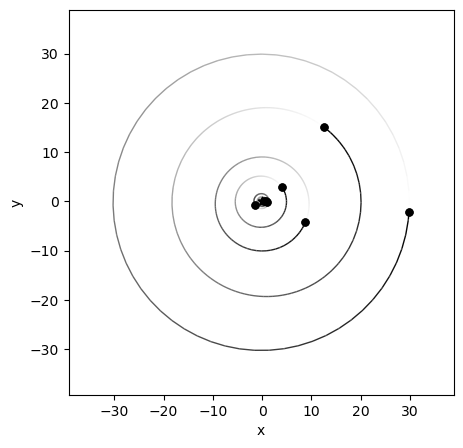

In [35]:
rb.OrbitPlot(sim)

In [36]:
asteroid_index = 2
row = merged_df.iloc[asteroid_index]
row

Des'n           00003
H_x              5.17
G                0.15
Epoch           K239D
M             37.0231
Peri.       247.73791
Node         169.8392
Incl.        12.99055
e            0.256213
n           .22600445
a            2.669263
propa        2.669376
da           0.000008
prope          0.2336
de            0.00001
propsini     0.229144
dsini        0.000003
g           43.858531
s          -61.476025
H_y              5.17
NumOpps           114
Name: 2, dtype: object

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulation.py:153: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


2.6361735671950375

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


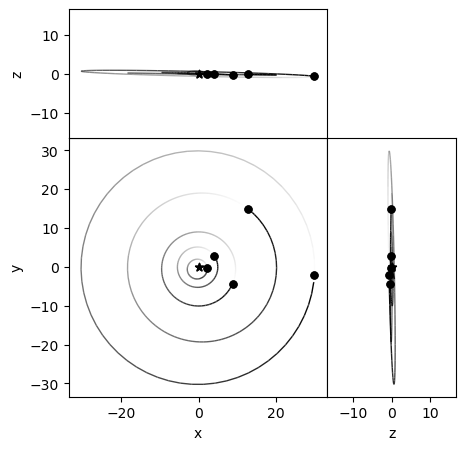

In [46]:
sim = rb.Simulation('planets.bin')
for i in range(4):
    sim.remove(1)
sim.add(a=row['a'], e=row['e'], inc=row['Incl.']*np.pi/180, Omega=row['Node']*np.pi/180, omega=row['Peri.']*np.pi/180, M=row['M'], primary=sim.particles[0])

# sim = rb.Simulation()
# sim.add("Sun", date=date)
# sim.add("Jupiter", date=date)
# sim.add("Saturn", date=date)
# sim.add("Uranus", date=date)
# sim.add("Neptune", date=date)

# sim.add(a=row['a'], e=row['e'], inc=row['Incl.']*np.pi/180, Omega=row['Node']*np.pi/180, omega=row['Peri.']*np.pi/180, M=row['M'], primary=sim.particles[0])
# sim.move_to_com()

rb.OrbitPlotSet(sim)

ps = sim.particles
ps[-1].a

CPU times: user 50.2 s, sys: 12 s, total: 1min 2s
Wall time: 1min 2s


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


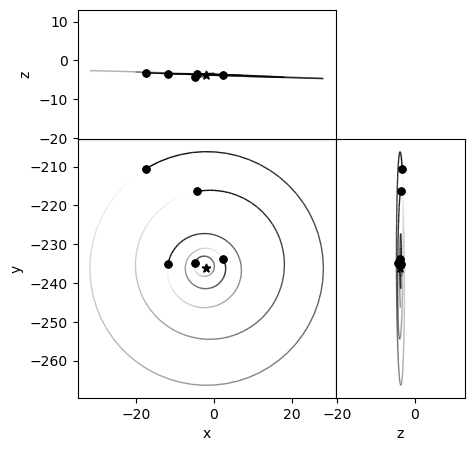

In [47]:
sim.integrator='whfast'
sim.dt = ps[1].P/100.
sim.ri_whfast.safe_mode = 0

Tfin_approx = 1.5e6*ps[-1].P
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 262144

save_file = integration_path / f"asteroid_integration_{row["Des'n"]}.sa"
sim.save_to_file(str(save_file), step=int(np.floor(total_steps/Nout)), delete_file=True)
sim.integrate(Tfin, exact_finish_time=0)
rb.OrbitPlotSet(sim)

In [48]:
results = cm.nbody_simulation_utilities.get_simarchive_integration_results(str(save_file),coordinates='heliocentric')

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


(2.6705249302721734, 2.669376)

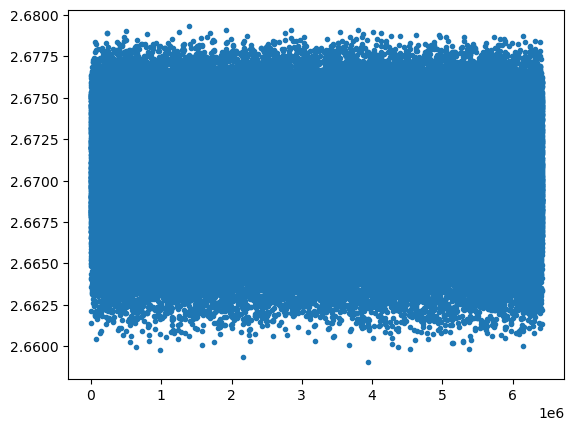

In [49]:
fig, ax = plt.subplots()
ax.plot(results['time'], results['a'][-1], '.')

results['a'][-1].mean(), merged_df.iloc[asteroid_index]['propa']

## Calculate frequencies of planets and asteroid

In [50]:
def closest_key_entry(d, target):
	"""
	Given a dictionary `d` with float keys and a target float `target`,
	returns a tuple (key, value) where the key is the one in `d`
	closest to `target`.

	Parameters
	----------
	d : dict
		Dictionary with float keys.
	target : float
		The float to compare keys against.

	Returns
	-------
	tuple
		The (key, value) pair whose key is closest to `target`.
	"""
	closest_key = min(d.keys(), key=lambda k: abs(k - target))
	return closest_key, d[closest_key]

In [51]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [52]:
if sim.N > 6:
	inner_planet_offset = 4
else:
	inner_planet_offset = 0

planets = ("Jupiter","Saturn","Uranus","Neptune", "Asteroid")
ecc_fmft_results = dict()
inc_fmft_results = dict()
for i,pl in enumerate(planets):
	ecc_fmft_results[pl] = fmft(results['time'],results['X'][i + inner_planet_offset],14)
	planet_e_freqs = np.array(list(ecc_fmft_results[pl].keys()))
	planet_e_freqs_arcsec_per_yr = planet_e_freqs * 60*60*180/np.pi * (2*np.pi)

	inc_fmft_results[pl] = fmft(results['time'],results['Y'][i + inner_planet_offset],8)
	planet_inc_freqs = np.array(list(inc_fmft_results[pl].keys()))
	planet_inc_freqs_arcsec_per_yr = planet_inc_freqs * 60*60*180/np.pi * (2*np.pi)

	print("")
	print(pl)
	print("g")
	print("-------")
	for g in planet_e_freqs[:6]:
		print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[pl][g])))
	print("s")
	print("-------")
	for g in planet_inc_freqs[:4]:
		print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(inc_fmft_results[pl][g])))


Jupiter
g
-------
+26.672 	 0.044206
+177.465 	 0.015694
+19.410 	 0.001842
-133611.408 	 0.000645
+328.258 	 0.000571
-56861.787 	 0.000396
s
-------
-00.000 	 0.013772
-165.481 	 0.003150
-04.346 	 0.000577
-18.807 	 0.000483

Saturn
g
-------
+177.465 	 0.048226
+26.672 	 0.032962
+328.258 	 0.001927
+8839.530 	 0.001545
+19.410 	 0.001532
-56861.787 	 0.001247
s
-------
-00.000 	 0.013767
-165.481 	 0.007853
-04.346 	 0.000556
-18.808 	 0.000392

Uranus
g
-------
+26.672 	 0.038097
+19.410 	 0.028990
+1918.381 	 0.002078
+04.232 	 0.001684
+177.465 	 0.001549
+96911.497 	 0.001350
s
-------
+00.000 	 0.013770
-18.807 	 0.008879
-04.346 	 0.000555
-165.481 	 0.000354

Neptune
g
-------
+04.230 	 0.009168
+19.410 	 0.003703
+26.672 	 0.001943
+49414.939 	 0.001352
+1918.381 	 0.000567
+78942.044 	 0.000164
s
-------
-00.000 	 0.013779
-04.347 	 0.005800
-18.807 	 0.001063
-14.692 	 0.000056

Asteroid
g
-------
+273.710 	 0.232260
+26.672 	 0.034018
+177.465 	 0.028411
-1039.791 	 0.

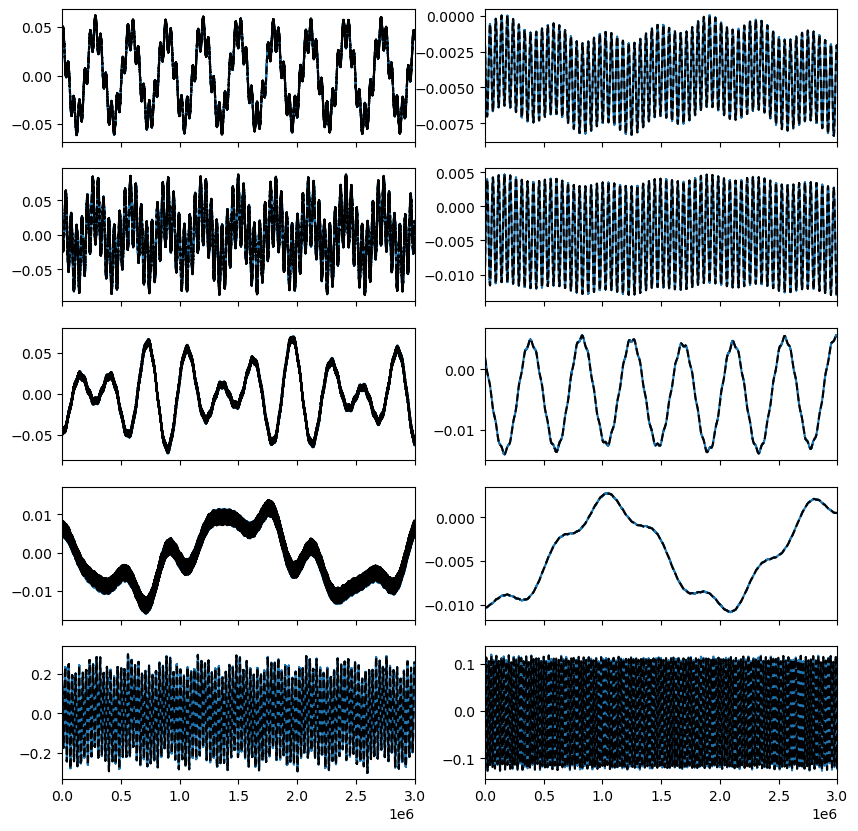

In [63]:
fig,ax = plt.subplots(sim.N-1 - inner_planet_offset,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
	freq_amp_dict = ecc_fmft_results[pl]
	ax[i,0].plot(results['time'],np.real(results['X'][i + inner_planet_offset]))
	zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
	ax[i,0].plot(results['time'],np.real(zsoln),'k--')

	freq_amp_dict = inc_fmft_results[pl]
	Ysolns.append(freq_amp_dict)
	ax[i,1].plot(results['time'],np.real(results['Y'][i + inner_planet_offset]))
	zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
	ax[i,1].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,3e6)
plt.show()

In [64]:
ARCSEC_PER_YR = 1/(180*60*60*2)
g_vec = np.zeros(4)
s_vec = np.zeros(3)

g_vec[:3] = np.array(list(ecc_fmft_results['Jupiter'].keys()))[:3]
g_vec[3] = list(ecc_fmft_results['Neptune'].keys())[0]
s_vec[0] = list(inc_fmft_results['Jupiter'].keys())[0]
s_vec[1] = list(inc_fmft_results['Jupiter'].keys())[2]
s_vec[2] = list(inc_fmft_results['Jupiter'].keys())[1]
omega_vec = np.concatenate((g_vec,s_vec))
g_and_s_arc_sec_per_yr = omega_vec / ARCSEC_PER_YR
g_and_s_arc_sec_per_yr

array([ 2.66720535e+01,  1.77465362e+02,  1.94098164e+01,  4.22984721e+00,
       -6.86281310e-06, -4.34643749e+00, -1.65481076e+02])

## Asteroid Eccentricity Prediction

In [65]:
def k_vec_generation(max_order = 3, size = 7):
	kvecs = []
	
	for order in range(1, max_order + 1):
		for positions in combinations_with_replacement(range(size), order):
			for variables in combinations_with_replacement([-1, 1], order):
				k = np.zeros(size, dtype = int)
				for i, n in zip(positions, variables):
					k[i] += n
				kvecs.append(k)
	kvecs = np.array(kvecs)
	indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
	kvecs = np.delete(kvecs, indices, axis=0)
	return kvecs

k_vecs = k_vec_generation(max_order = 3, size = omega_vec.size)
k_vecs

use_k_vecs = False

In [66]:
eye_N = np.eye(omega_vec.size,dtype = int)
x_dicts = []
for pl in planets:
	print(pl)    
	print("-"*len(pl))
	print("kvec \t\t\t omega \t err. \t amplitude")
	x_dict = {}
	if use_k_vecs:
		for k in k_vecs:
			omega=k@omega_vec
			omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
			omega_error = np.abs(omega_N/omega-1)
			if omega_error<0.001:
				print (k,"\t{:+07.2f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
				x_dict[tuple(k)] = amp
	else:
		for i,omega_i in enumerate(omega_vec[:4]):
			omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega_vec[i])
			omega_error = np.abs(omega_N/omega_i-1)
			if omega_error<0.001:
				print(eye_N[i],"\t{:+07.2f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
				x_dict[tuple(eye_N[i])] = amp
		#NL terms
		for a in range(7):
			for b in range(a,7):
				for c in range(7):
					if c==a:
						continue
					if c==b:
						continue
					k = np.zeros(7,dtype = int)
					k[a] +=1
					k[b] +=1
					k[c] -=1
					omega=k@omega_vec
					omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
					omega_error = np.abs(omega_N/omega-1)
					if omega_error<0.001:
						print (k,"\t{:+07.2f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
						x_dict[tuple(k)] = amp
	x_dicts.append(x_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+026.67	0 	0.04
[0 1 0 0 0 0 0] 	+177.47	0 	0.02
[0 0 1 0 0 0 0] 	+019.41	0 	0.002
[ 1  1 -1  0  0  0  0] 	+184.73	5e-06,	0.0002
[-1  2  0  0  0  0  0] 	+328.26	2e-06,	0.0006
[-1  1  1  0  0  0  0] 	+170.20	5e-06,	0.0002
[ 0  1  0  1 -1  0  0] 	+181.70	0.0009,	0.0001
[ 0  0  1  0  1  0 -1] 	+184.89	0.0009,	0.0002
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+026.67	9e-09 	0.03
[0 1 0 0 0 0 0] 	+177.47	1e-10 	0.05
[0 0 1 0 0 0 0] 	+019.41	6e-07 	0.002
[ 1  1 -1  0  0  0  0] 	+184.73	5e-06,	0.0006
[-1  2  0  0  0  0  0] 	+328.26	2e-06,	0.002
[-1  1  1  0  0  0  0] 	+170.20	5e-06,	0.0006
[ 0  1  0  1 -1  0  0] 	+181.70	0.0009,	0.0004
[ 0  0  1  0  1  0 -1] 	+184.89	0.0009,	0.0006
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+026.67	4e-07 	0.04
[0 1 0 0 0 0 0] 	+177.47	2e-06 	0.002
[0 0 1 0 0 0 0] 	+019.41	1e-06 	0.03
[0 0 0 1 0 0 0] 	+004.23	0.0005 	0.002
[ 2  0 -1  0  0  0  0] 	+033

In [67]:
eye_N = np.eye(omega_vec.size,dtype = int)
y_dicts = []
for pl in planets:
	print(pl)    
	print("-"*len(pl))
	print("kvec \t\t\t omega \t err. \t amplitude")
	y_dict = {}
	for i,omega_i in enumerate(omega_vec[4:]):
		omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega_vec[i])
		omega_error = np.abs(omega_N/omega_i-1)
		if omega_error<0.001:
			print (eye_N[i],"\t{:+07.2f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
			y_dict[tuple(eye_N[i])] = amp
	#NL terms
	for a in range(7):
		for b in range(a,7):
			for c in range(7):
				if c==a:
					continue
				if c==b:
					continue
				k = np.zeros(7,dtype = int)
				k[a] +=1
				k[b] +=1
				k[c] -=1
				omega=k@omega_vec
				omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega)
				omega_error = np.abs(omega_N/omega-1)
				if omega_error<0.001:
					print (k,"\t{:+07.2f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
					y_dict[tuple(k)] = amp
	y_dicts.append(y_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	-000.00	0 	0.01
[ 0  2  0  0  0  0 -1] 	+520.41	1e-06,	1e-05
[-1  1  0  0  0  0  1] 	-014.69	0.0003,	2e-05
[ 0  0  0 -1  1  0  1] 	-169.71	0.0007,	2e-05
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[ 1  1  0  0  0  0 -1] 	+369.62	5e-07,	2e-05
[ 0  2  0  0  0  0 -1] 	+520.41	1e-06,	4e-05
[ 0  0  0 -1  1  0  1] 	-169.71	0.0007,	6e-05
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[-1  1  0  0  0  0  1] 	-014.69	0.0002,	0.0003
Neptune
-------
kvec 			 omega 	 err. 	 amplitude
[-1  1  0  0  0  0  1] 	-014.69	0.0003,	6e-05
[-1  0  1  0  0  1  0] 	-011.61	0.0001,	2e-05
Asteroid
--------
kvec 			 omega 	 err. 	 amplitude


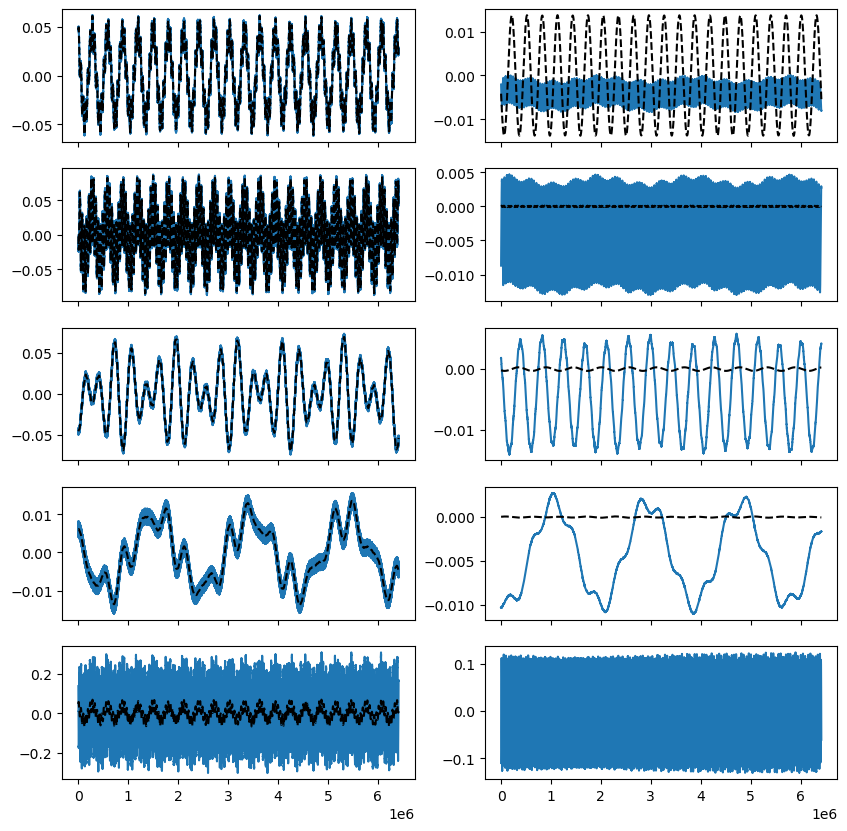

In [68]:
fig,ax = plt.subplots(sim.N-1 - inner_planet_offset,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
	freq_amp_dict = ecc_fmft_results[pl]
	ax[i,0].plot(results['time'],np.real(results['X'][i + inner_planet_offset]))
	zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in x_dicts[i].items()],axis=0)
	ax[i,0].plot(results['time'],np.real(zsoln),'k--')


	freq_amp_dict = inc_fmft_results[pl]
	ax[i,1].plot(results['time'],np.real(results['Y'][i + inner_planet_offset]))
	if y_dicts[i]:
		zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in y_dicts[i].items()],axis=0)
		ax[i,1].plot(results['time'],np.real(zsoln),'k--')
# plt.xlim(0,1e7)
plt.show()

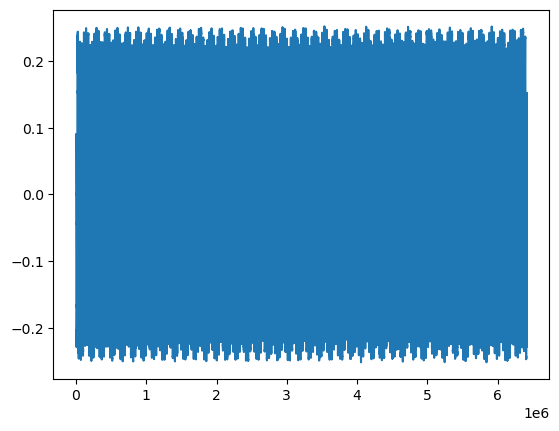

In [69]:
freq_amp_dict = ecc_fmft_results['Asteroid']
zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + np.angle(amp))) for k,amp in x_dicts[-1].items()],axis=0)
soln_wo_planets = results['X'][i + inner_planet_offset] - zsoln
plt.plot(results['time'], np.real(soln_wo_planets))

In [71]:
ecc_fmft_result = fmft(results['time'], soln_wo_planets, 14)

asteroid_e_freqs = np.array(list(ecc_fmft_result.keys()))
asteroid_e_freqs_arcsec_per_yr = asteroid_e_freqs * 60*60*180/np.pi * (2*np.pi)

print("")
print(pl)
print("g")
print("-------")
for g in asteroid_e_freqs[:6]:
    print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_result[g])))


Asteroid
g
-------
+273.710 	 0.232259
-1039.791 	 0.013315
+520.577 	 0.001917
+491.269 	 0.001588
+56.150 	 0.001563
+369.785 	 0.001280
